# Comparing grit to mp-value

mp-value was described in [Hutz et al. 2012](https://doi.org/10.1177/1087057112469257).
The mp-value metric calculates a Mahalanobis distance between treatment and control perturbations, and determines significance through random permutations.
The mp-value metric can be interpreted as an empirical p value indicating how different the treatment perturbations are from controls.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import plotnine as gg

In [2]:
results_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")
output_dir = pathlib.Path("figures")

In [3]:
# Load cell health grit scores
cell_health_grit_file = pathlib.Path(f"{results_dir}/cell_health_grit.tsv")

cell_health_grit_df = (
    pd.read_csv(cell_health_grit_file, sep="\t")
    .query("barcode_control == 'cutting_control'")
    .query("cor_method == 'pearson'")
    .query("grit_replicate_summary_method == 'mean'")
)

print(cell_health_grit_df.shape)
cell_health_grit_df.head()

(357, 7)


,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,mean
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson,mean
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson,mean
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson,mean


In [4]:
# Load mp value grit scores
cell_health_mpvalue_file = pathlib.Path(f"{results_dir}/cell_health_mpvalue.tsv")

cell_health_mpvalue_df = pd.read_csv(cell_health_mpvalue_file, sep="\t").query(
    "barcode_control == 'cutting_control'"
)

cell_health_mpvalue_df = cell_health_mpvalue_df.assign(
    mp_value_neglog=-1 * np.log10(cell_health_mpvalue_df.mp_value)
)

mask = cell_health_mpvalue_df.mp_value_neglog == np.inf
cell_health_mpvalue_df.loc[mask, "mp_value_neglog"] = cell_health_mpvalue_df.loc[
    ~mask, "mp_value_neglog"
].max()

print(cell_health_mpvalue_df.shape)
cell_health_mpvalue_df.head()

(1428, 6)


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


,Metadata_pert_name,mp_value,cell_line,barcode_control,num_permutations,mp_value_neglog
0,AKT1-1,0.1,HCC44,cutting_control,10,1.000000
1,AKT1-2,0.2,HCC44,cutting_control,10,0.698970
2,ARID1B-1,0.2,HCC44,cutting_control,10,0.698970
3,ARID1B-2,0.3,HCC44,cutting_control,10,0.522879
4,ATF4-1,0.0,HCC44,cutting_control,10,3.698970


In [5]:
combined_df = cell_health_grit_df.merge(
    cell_health_mpvalue_df,
    left_on=["perturbation", "cell_line", "barcode_control"],
    right_on=["Metadata_pert_name", "cell_line", "barcode_control"],
)

print(combined_df.shape)
combined_df.head()

(1428, 11)


,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,Metadata_pert_name,mp_value,num_permutations,mp_value_neglog
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean,AKT1-1,0.1000,10,1.000000
1,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean,AKT1-1,0.1900,100,0.721246
2,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean,AKT1-1,0.1730,1000,0.761954
3,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean,AKT1-1,0.1728,5000,0.762456
4,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,mean,AKT1-2,0.2000,10,0.698970


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.5 x 3 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/cell_health_grit_mpvalue_comparison.png


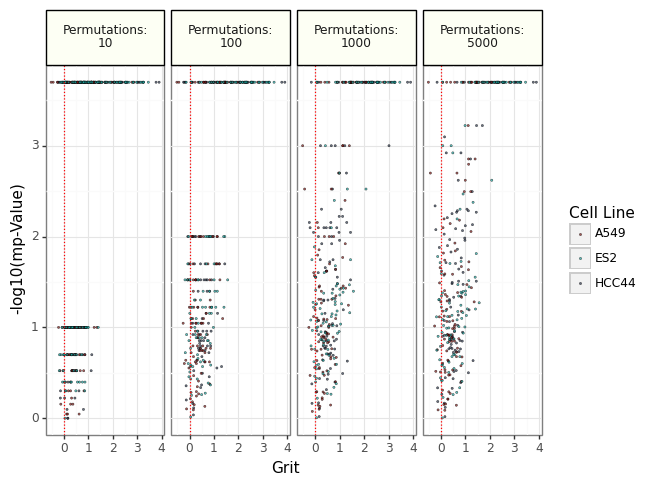

<ggplot: (671381498)>

In [6]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}


def col_func(s):
    return f"Permutations:\n{s}\n"


mp_value_comparison_gg = (
    gg.ggplot(combined_df.dropna(), gg.aes(x="grit", y="mp_value_neglog"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=0.7, stroke=0.2, alpha=0.7)
    + gg.geom_vline(xintercept=0, linetype="dotted", color="red")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.xlab("Grit")
    + gg.ylab("-log10(mp-Value)")
    + gg.facet_wrap("~num_permutations", ncol=4, labeller=gg.labeller(cols=col_func))
    + gg.theme_bw()
    + gg.theme(
        strip_background=gg.element_rect(color="black", height=0.15, fill="#fdfff4")
    )
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_mpvalue_comparison.png")
mp_value_comparison_gg.save(output_file, dpi=500, height=3, width=6.5)

mp_value_comparison_gg

## Overlay replicate correlation

In [7]:
reprod_file = pathlib.Path(f"{results_dir}/cell_health_replicate_reproducibility.tsv")
reprod_df = pd.read_csv(reprod_file, sep="\t")

print(reprod_df.shape)
reprod_df.head()

(357, 5)


,cell_line,group,perturbation,median_replicate_correlation,median_control_correlation
0,A549,AKT1,AKT1-1,0.022261,0.016903
1,A549,AKT1,AKT1-2,-0.302957,0.002390
2,A549,ARID1B,ARID1B-1,0.311278,0.027581
3,A549,ARID1B,ARID1B-2,0.405716,0.062314
4,A549,ATF4,ATF4-1,0.821153,0.081103


In [8]:
full_df = combined_df.query("num_permutations == 5000").merge(
    reprod_df, on=["perturbation", "group", "cell_line"]
)

print(full_df.shape)
full_df.head()

(357, 13)


,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,Metadata_pert_name,mp_value,num_permutations,mp_value_neglog,median_replicate_correlation,median_control_correlation
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean,AKT1-1,0.1728,5000,0.762456,0.312738,-0.015761
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,mean,AKT1-2,0.1394,5000,0.855737,0.152056,0.007979
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson,mean,ARID1B-1,0.1290,5000,0.889410,0.186862,0.054083
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson,mean,ARID1B-2,0.1722,5000,0.763967,0.211846,0.033912
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson,mean,ATF4-1,0.0012,5000,2.920819,0.754919,0.118991


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.5 x 3 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/cell_health_mpvalue_replicatereproducibility_comparison.png


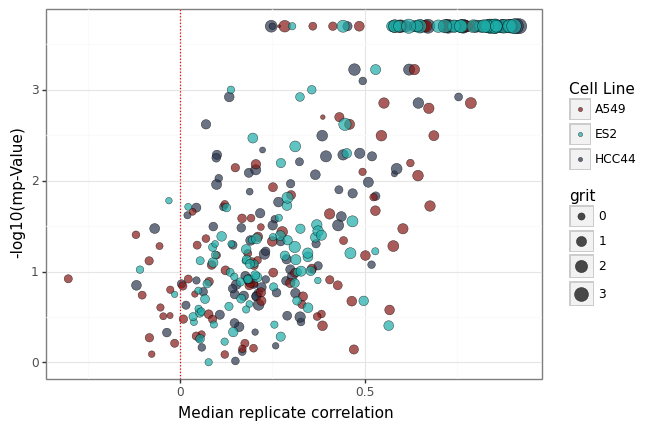

<ggplot: (672970740)>

In [9]:
mp_value_comparison_gg = (
    gg.ggplot(
        full_df.dropna(), gg.aes(x="median_replicate_correlation", y="mp_value_neglog")
    )
    + gg.geom_point(gg.aes(fill="cell_line", size="grit"), stroke=0.2, alpha=0.7)
    + gg.geom_vline(xintercept=0, linetype="dotted", color="red")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.xlab("Median replicate correlation")
    + gg.ylab("-log10(mp-Value)")
    + gg.theme_bw()
    + gg.theme(
        strip_background=gg.element_rect(color="black", height=0.15, fill="#fdfff4")
    )
)


output_file = pathlib.Path(
    f"{output_dir}/cell_health_mpvalue_replicatereproducibility_comparison.png"
)
mp_value_comparison_gg.save(output_file, dpi=500, height=3, width=6.5)

mp_value_comparison_gg